In [1]:
import os
# Avoid Tensorflow yelling
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from copy import deepcopy
from numpy.lib.stride_tricks import sliding_window_view
from pe_extractor.cnn import generator_nsb
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
import tensorflow as tf
%matplotlib widget

In [2]:

# generator variables
n_sample = 100000
n_sample_init = 0
batch_size = 1
shift_proba_bin = 30
sigma_smooth_pe_ns = 0 #2.
bin_size_ns = 0.5   
sampling_rate_mhz = 200 #200 MHz is the sampling of terzina
                        #250 SST1M
                        #1000 LST + MST
                        #résolution 100 picosecondes 
pe_rate_mhz = 20 # 1 to 150 MHz
noise_lsb=1.5 # 0.5, 1, 1.5 options
amplitude_gain=5.
relative_gain_std=0.05
# -------------------------------
# Generator data
# -------------------------------
sampling_period_s = 1 / (sampling_rate_mhz * 1e6)
bin_per_sample = ceil(((sampling_period_s) * 1e9) / bin_size_ns)
# increase output resolution
bin_resolution_multiplier = 1
bin_per_sample = ceil(bin_per_sample / bin_resolution_multiplier)

gen = generator_nsb(
    n_event=None, batch_size=batch_size, n_sample=n_sample + n_sample_init,
    n_sample_init=n_sample_init, pe_rate_mhz=pe_rate_mhz,
    bin_size_ns=bin_size_ns, sampling_rate_mhz=sampling_rate_mhz,
    amplitude_gain=amplitude_gain, noise_lsb=noise_lsb,
    sigma_smooth_pe_ns=sigma_smooth_pe_ns, baseline=0,
    relative_gain_std=relative_gain_std, shift_proba_bin=shift_proba_bin, dtype=np.float64
)

print(f"Using sampling period of {sampling_period_s}s")
print(f"Having ({bin_per_sample}, {bin_resolution_multiplier}) bins for every sample")

Using sampling period of 5e-09s
Having (10, 1) bins for every sample


In [3]:
def ns_scale(start, size, resolution = 1):
    return np.linspace((sampling_period_s * 1e9) * start, (sampling_period_s * 1e9) * (start+size), num=size * resolution)

In [4]:
# CNN variables
train_size = int(0.8 * n_sample)
window_size = 7
conv_size = 4

data = next(gen)
summed_bins = np.sum(data[1][0].reshape(-1, bin_per_sample), axis=1)
summed_bins_bool = list(map(lambda x: 1 if x > 0 else 0, summed_bins))

print("Generated data : ", data[0][0].shape)
print("Generated outputs : ", summed_bins.shape)

sliced_data = sliding_window_view(data[0][0], window_size)
sliced_results = sliding_window_view(summed_bins, window_size * bin_resolution_multiplier)

# split the data into training/test data
dataset = list(zip(deepcopy(sliced_data), deepcopy(sliced_results)))
# np.random.shuffle(dataset)

train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]
np.random.shuffle(train_dataset)
train_data, train_results = zip(*train_dataset)
train_data, train_results = np.asarray(train_data), np.asarray(train_results)
test_data, test_results = zip(*test_dataset)
test_data, test_results = np.asarray(test_data), np.asarray(test_results)

print("Input Shape : " + str(train_data[0].shape))
print("Expected Output Shape : " + str(train_results[0].shape))

Generated data :  (100000,)
Generated outputs :  (100000,)
Input Shape : (7,)
Expected Output Shape : (7,)


In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(window_size, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(4, (conv_size)),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(window_size * bin_resolution_multiplier, activation='relu'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 7, 1)              4         
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 4, 4)              20        
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 4)              0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 2, 4)              0         
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 16)                1

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=adam_optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

model.fit(train_data, train_results, epochs=10, validation_data=(test_data, test_results))

I0000 00:00:1717160636.573415    7917 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 8s 2ms/step - loss: 0.0765 - mean_absolute_error: 0.1169 - val_loss: 0.0709 - val_mean_absolute_error: 0.1070


In [7]:
# # --------------------------------
# # Moving window display NanoSecond scale
# # --------------------------------
# i = 0
# resultsYMax = np.max(test_results) + 0.1
# fig = plt.figure(figsize=(12, 5))

# def update():
#     plt.clf()
#     ax1 = plt.subplot(211)
#     shape = test_data[0].shape[0]
#     # print(shape, i)
#     # print(shape * i, shape * (i+1))
#     # print("Results shape : " + str(test_results[i].shape))
#     # print("Scale shape : " + str(ns_scale(shape * i, shape, bin_resolution_multiplier).shape))
#     # print("Model shape : " + str(model.predict(test_data[i][None,], verbose=0)[0].shape))
#     ax1.plot(ns_scale(shape * i, shape), test_data[i], label='Sensor data')
#     ax1.set_ylabel('Amplitude')
#     ax2 = plt.subplot(212, sharex=ax1)
#     ax2.set_ylim(-0.1,resultsYMax)
#     ax2.plot(ns_scale(shape * i, shape, bin_resolution_multiplier), test_results[i], label='Truth')
#     # [None, ] is for the batch array dimension, since it's a single event, just add none
#     ax2.plot(ns_scale(shape * i, shape, bin_resolution_multiplier), model.predict(test_data[i][None,], verbose=0)[0], '--r', label='Prediction')
#     plt.xlabel('Sample index')
#     plt.draw()

# def press(event):
#     global i, ax1, ax2
#     # Move window left or right
#     if event.key == 'left':
#         i-=1
#     elif event.key == 'right':
#         i+=1
#     update()

# fig.canvas.mpl_connect('key_press_event', press)
# update()
# plt.show()

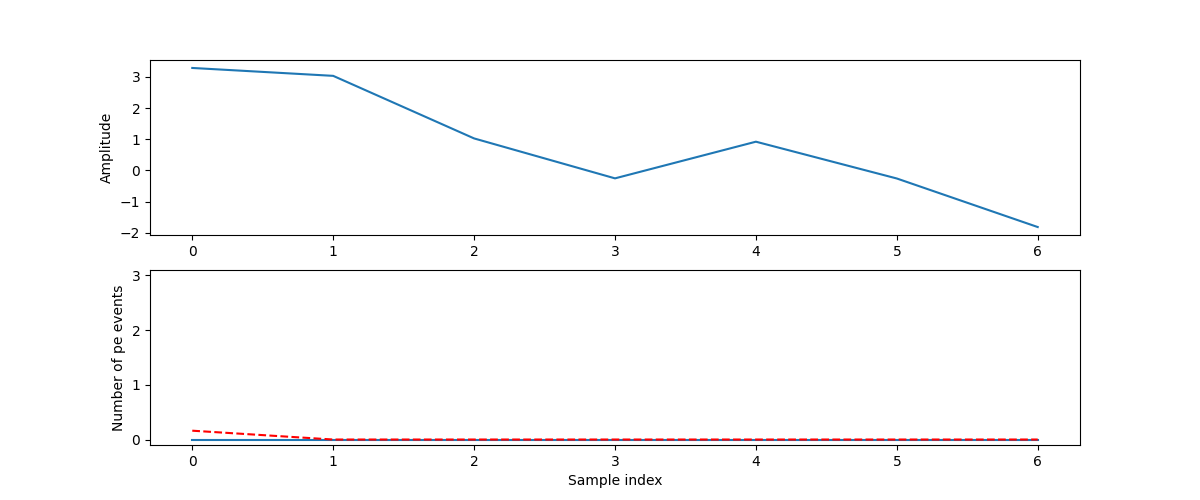

In [8]:
# --------------------------------
# Moving window display
# --------------------------------
i = 0
resultsYMax = np.max(test_results) + 0.1
fig = plt.figure(figsize=(12, 5))

def update():
    plt.clf()
    ax1 = plt.subplot(211)
    ax1.plot(test_data[i], label='Sensor data')
    ax1.set_ylabel('Amplitude')
    ax2 = plt.subplot(212, sharex=ax1)
    ax2.set_ylim(-0.1,resultsYMax)
    ax2.set_ylabel('Number of pe events')
    ax2.plot(test_results[i], label='Truth')
    # [None, ] is for the batch array dimension, since it's a single event, just add none
    ax2.plot(model.predict(test_data[i][None,], verbose=0)[0], '--r', label='Prediction')
    plt.xlabel('Sample index')
    plt.draw()

def press(event):
    global i, ax1, ax2
    # Move window left or right
    if event.key == 'left':
        i-=1
    elif event.key == 'right':
        i+=1
    update()

fig.canvas.mpl_connect('key_press_event', press)
update()
plt.show()

   1/3125 [..............................] - ETA: 47s

3125/3125 [==============================] - 3s 950us/step


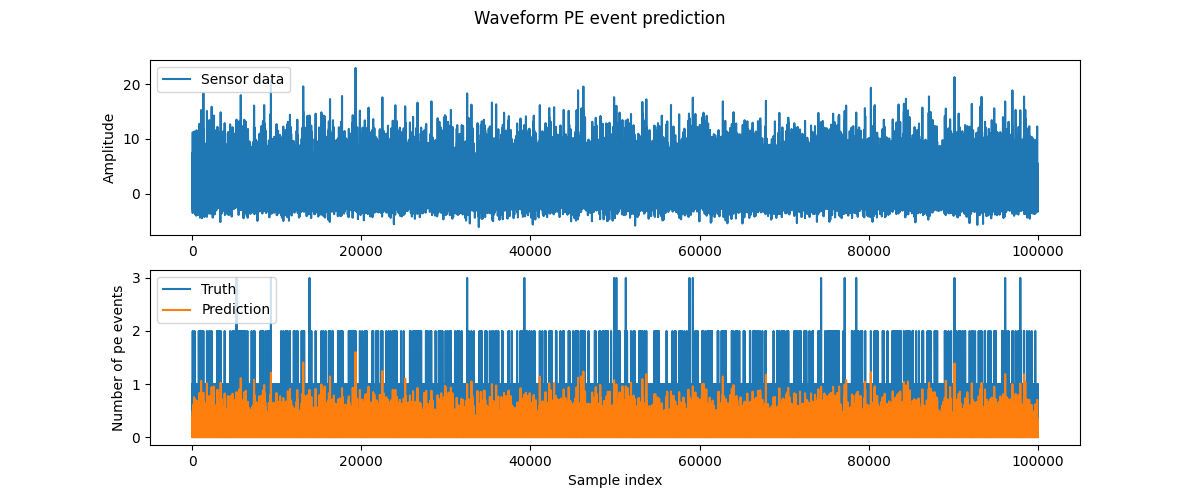

In [9]:
# --------------------------------
# Whole waveform display
# --------------------------------

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Waveform PE event prediction')
ax1 = plt.subplot(211)
ax1.plot(data[0][0], label='Sensor data')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax2 = plt.subplot(212, sharex=ax1)
ax2.set_ylabel('Number of pe events')
ax2.plot(summed_bins, label='Truth')
results = model.predict(sliced_data)
results = list(map(lambda x: x[0], results))
ax2.plot(results, label='Prediction')
ax2.legend()
plt.xlabel('Sample index')

plt.show()

In [70]:
import importlib
import signal_sense
import itertools
import operator

importlib.reload(signal_sense)

metrics_result = signal_sense.run_tests(model, window_size)

Running 24 tests on model
RUN_0: config={'pe_rate_mhz': 20, 'noise_lsb': 0.0} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_1: config={'pe_rate_mhz': 20, 'noise_lsb': 0.25} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_2: config={'pe_rate_mhz': 20, 'noise_lsb': 0.5} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_3: config={'pe_rate_mhz': 20, 'noise_lsb': 0.75} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_4: config={'pe_rate_mhz': 20, 'noise_lsb': 1.0} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_5: config={'pe_rate_mhz': 20, 'noise_lsb': 1.25} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_6: config={'pe_rate_mhz': 50, 'noise_lsb': 0.0} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_7: config={'pe_rate_mhz': 50, 'noise_lsb': 0.25} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_8: config={'pe_rate_mhz': 50, 'noise_lsb': 0.5} | bps=10 | input=(100000,) | expected_output=(100000,)
RUN_9: 

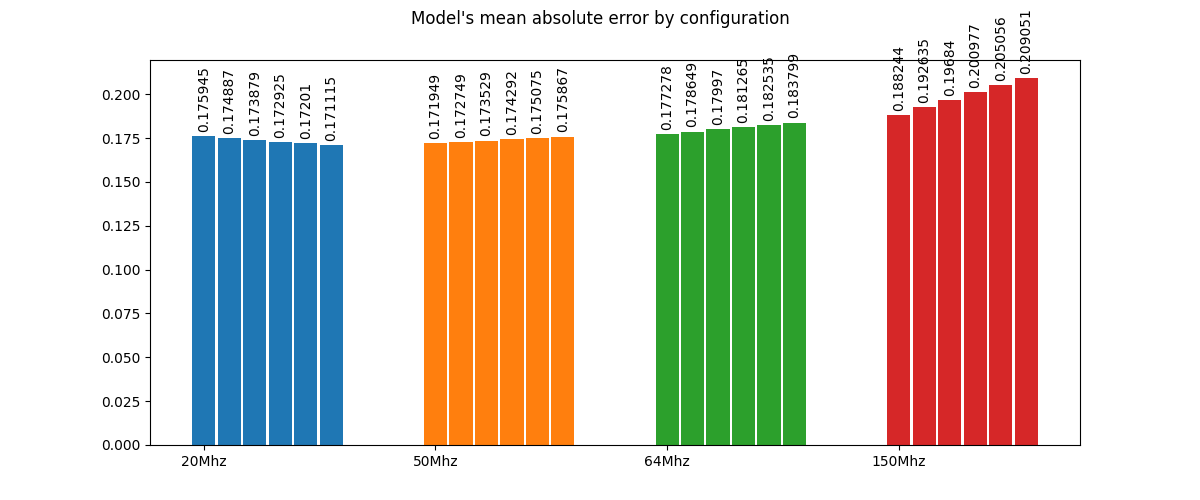

In [69]:
grouped_by_pe_rate = [{ "label": f"{k}Mhz", "data" : list(g)} for k, g in itertools.groupby(metrics_result, key=operator.itemgetter('pe_rate_mhz'))]

fig = plt.figure(figsize=(12, 5))
fig.suptitle('Model\'s mean absolute error by configuration')

x = np.arange(len(grouped_by_pe_rate))
bar_width = 0.1
multiplier = 0

ax = fig.subplots(1)
for i, entry in enumerate(grouped_by_pe_rate):
    bar_label = [x["noise_lsb"] for x in entry["data"]]
    bar_values = np.array([x["mean_absolute_error"] for x in entry["data"]]).flatten()
    bar_locations = i + np.arange(len(bar_values)) * (bar_width + 0.01)
    
    rects = ax.bar(bar_locations, bar_values, bar_width, label=bar_label)
    ax.bar_label(rects, rotation = 90, padding=3)
    multiplier+=1

ax.set_xticks(x, [x["label"] for x in grouped_by_pe_rate])
# ax.legend(loc='upper left', ncols=4)

plt.show()

In [11]:
# model = tf.keras.models.load_model('pe_extractor_multi.keras')


In [12]:
# model.save('pe_extractor_multi.keras')

In [13]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

ModuleNotFoundError: No module named 'tensorflow_model_optimization'

In [ ]:
q_aware_model = quantize_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
